# Extracting Keywords Script

In [4]:
news_data = []

In [5]:
# code for extracting news data using mediastack api. Data has already been extracted and is saved in the newsarticle.json file
# Thus, code is commented out

# import http.client, urllib.parse, json

# conn = http.client.HTTPConnection('api.mediastack.com')

# for i in range(0, 6):
#     params = urllib.parse.urlencode({
#         'access_key': '38f726aef9cabcd89940e27f93c99e3f',
#         'categories': 'politics',
#         'countries': 'us',
#         'sort': 'published_desc',
#         'limit': 100,
#         'offset': i*100,
#         # 'keywords': 'election',
#         'date': '2024-10-15,2024-11-26'
#     })

#     conn.request('GET', '/v1/news?{}'.format(params))
    
#     res = conn.getresponse()
#     data = res.read().decode('utf-8')
#     news_data += list(json.loads(data)["data"])

In [127]:
def read_file(file_name):
    with open(file_name, "r") as json_file:
        data = json.load(json_file)
    return data


def write_file(data, file_name):
    with open(file_name, "w") as json_file:
        json.dump(data, json_file, indent=4)  # `indent=4` makes it pretty-printed

news_data = read_file("newsarticles.json")

282


In [128]:
# find cosine similarity of relevant categories to the election

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Sample documents
documents = news_data

# Create a count matrix
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(documents).toarray()

# Create a word-to-index mapping
vocab = vectorizer.get_feature_names_out()
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Find co-occurrence vectors for a target word
keywords = {"economy": [], "democracy": [], "security": [], "immigration": [], "education": [], "healthcare": [], "abortion": []}
for keyword in keywords:
    if keyword in word_to_index:
        target_idx = word_to_index[keyword]
        target_vector = count_matrix[:, target_idx]
    
        # Calculate cosine similarity with all other words
        similarities = cosine_similarity(target_vector.reshape(1, -1), count_matrix.T).flatten()
    
        # Get top related words
        related_indices = similarities.argsort()[::-1][1:21]
        print(f"Words most related to '{keyword}':")
        for idx in related_indices:
            keywords[keyword].append(vocab[idx])
        print(keywords[keyword])
    else:
        print(f"'{target_word}' not found in the vocabulary.")

Words most related to 'economy':
['prices', 'inflation', 'triggering', 'stock', 'scores', 'expensive', 'felt', 'rates', 'respondents', 'professional', 'economic', 'stamps', 'repercussions', 'roxanne', 'afloat', 'aquaculture', 'priced', 'manageable', 'succumbing', 'necessities']
Words most related to 'democracy':
['siphoned', 'mudde', 'legalized', 'hence', 'capitalism', 'rectify', 'columns', 'newest', 'reich', 'acquisitions', 'robertreich', 'stalled', 'nausea', 'misallocation', 'inbox', 'rigs', 'cas', 'eldercare', 'summoned', 'corporations']
Words most related to 'security':
['social', 'shortfall', 'finances', 'insolvency', '2031', 'footing', 'mismanage', 'proposing', 'waving', 'trustees', 'insolvent', 'modernize', 'holland', 'ss', '2033', 'breck', 'dumas', 'angrily', 'buckle', 'oasi']
Words most related to 'immigration':
['immigrants', 'policies', 'border', 'forgiveness', 'country', 'about', 'sues', 'migrants', 'illegally', 'wanted', 'harris', 'illegal', 'said', 'did', 'from', 'trump',

In [130]:
# save to file
write_file(keywords, "keywords.json")

# End of Script
The rest of the script is commented out, and was used to initially extract the data from the API

In [6]:
# check_dup = set()
# for article in news_data:
#     check_dup.add(article["url"])
# print(len(check_dup))

# check_sources = set()
# for article in news_data:
#     check_sources.add(article["source"])
# print(check_sources)

557
{'The Guardian', 'FOX News - Politics', 'The New York Times', 'Yahoo News', 'Sky News - Politics'}


In [96]:
# # Find Articles from specific sources
# articles_by_source = {'CNN': [], 'FOX News': [], 'BBC News': [], 'The Guardian': [], 'CNBC': []}

# for article in news_data:
#     for source in articles_by_source:
#         if source in article["source"]:
#             articles_by_source[source].append(article)

# for source, article_list in articles_by_source.items():
#     print(source + " has " + str(len(article_list)))


CNN has 18
FOX News has 97
BBC News has 12
The Guardian has 28
CNBC has 74
Yahoo News has 8


In [124]:
# import json
# # for article in news_data[-5:]:
# for article in articles_by_source['The Guardian']:
#     print("Title: " + article["title"])
#     print("Description: " + article["description"])
#     print("Source: " + article["source"])
#     print("Publish date: " + article["published_at"] + "\n")
#     print("URL: " + article["url"])

# # print(data.decode('utf-8'))
# # print(type("hi"))

In [126]:
# from datetime import datetime
# import pytz
# # Check Dates


# # Define time cutoffs
# # Oct 15th 8pm EST
# before_elec_time = datetime(2024, 10, 15, 20, 0, 0, tzinfo=pytz.timezone('America/New_York')).astimezone(pytz.utc).timestamp()
# # Nov 26th 8pm EST
# after_elec_time = datetime(2024, 11, 26, 20, 0, 0, tzinfo=pytz.timezone('America/New_York')).astimezone(pytz.utc).timestamp()

# # Define two ISO 8601 date strings
# article_date = "2024-10-16T19:32:35+00:00"

# # Parse strings into datetime objects
# article_date = datetime.fromisoformat(article_date)

# # Convert ISO datetime to UTC timestamp
# iso_date_timestamp = article_date.timestamp()

# print(iso_date_timestamp)

# if iso_date_timestamp < before_elec_time:
#     print("this article was written before our cutoff and should not be considered")
# else:
#     print("keep this article in!")

In [14]:
# # Extract articles
# # class="col-body

# import requests
# from bs4 import BeautifulSoup

# def extract_yahoo_article(url):
#     # Step 2: Fetch the webpage HTML
#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Raise an error for bad status codes (e.g., 404, 500)
#     except requests.RequestException as e:
#         print(f"Error fetching the URL: {e}")
#         exit()
#     # Step 3: Parse the HTML
#     soup = BeautifulSoup(response.text, 'html.parser')  # Or use 'html.parser'
    
#     # Step 4: Extract the article body
#     # Adjust the class or tag based on the specific structure of the news website
#     article_body = soup.find_all('p', class_='col-body')
    
#     if article_body:
#         article_text = ""
#         for lines in article_body:
#         # Extract and clean the text
#             article_text += lines.get_text(separator="\n").strip()
#             # print(article_text)
#         return article_text
#     else:
#         print("Could not find the article body. Please check the class or tag.")
#         return None

# def extract_guardian_article(url):
#     # Step 2: Fetch the webpage HTML
#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Raise an error for bad status codes (e.g., 404, 500)
#     except requests.RequestException as e:
#         print(f"Error fetching the URL: {e}")
#         exit()
#     # Step 3: Parse the HTML
#     soup = BeautifulSoup(response.text, 'html.parser')  # Or use 'html.parser'
    
#     # Step 4: Extract the article body
#     article_body = soup.find('div', id ='maincontent')
    
#     if article_body:
#         article_text = article_body.get_text(separator="\n").strip()
#         return article_text
#         # print(article_text)
#     else:
#         print("Could not find the article body. Please check the class or tag.")
#         return None

# # def extract_new_york_article(url):
# #     # Step 2: Fetch the webpage HTML
# #     try:
# #         response = requests.get(url)
# #         response.raise_for_status()  # Raise an error for bad status codes (e.g., 404, 500)
# #     except requests.RequestException as e:
# #         print(f"Error fetching the URL: {e}")
# #         exit()
# #     # Step 3: Parse the HTML
# #     soup = BeautifulSoup(response.text, 'html.parser')  # Or use 'html.parser'
    
# #     # Step 4: Extract the article body
# #     article_body = soup.find('section', name ='articleBody')
    
# #     if article_body:
# #         article_text = article_body.get_text(separator="\n").strip()
# #         print(article_text)
# #     else:
# #         print("Could not find the article body. Please check the class or tag.")

# def extract_fox_news_article(url):
#     # Step 2: Fetch the webpage HTML
#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Raise an error for bad status codes (e.g., 404, 500)
#     except requests.RequestException as e:
#         print(f"Error fetching the URL: {e}")
#         exit()
#     # Step 3: Parse the HTML
#     soup = BeautifulSoup(response.text, 'html.parser')  # Or use 'html.parser'
    
#     # Step 4: Extract the article body
#     article_body = soup.find('div', class_='article-content')
    
#     if article_body:
#         article_text = article_body.get_text(separator="\n").strip()
#         # print(article_text)
#         return article_text
#     else:
#         print("Could not find the article body. Please check the class or tag.")
#         return None



# # Step 1: Define the URL
# # url = " https://www.nytimes.com/2024/11/27/us/politics/elon-musk-federal-budget.html"

# # extract_new_york_article(url)


In [15]:
# documents = []
# unsupported_art = []
# for article in news_data:
#     url = article["url"]
#     match article["source"]:
#         case 'The Guardian':
#             documents.append(extract_guardian_article(url))
#         case 'FOX News - Politics':
#             documents.append(extract_fox_news_article(url))
#         case 'Yahoo News':
#             documents.append(extract_yahoo_article(url))
#         case _:
#             unsupported_art.append(article)
# print(len(documents))
# print(len(unsupported_art))
                    
    

Could not find the article body. Please check the class or tag.
Could not find the article body. Please check the class or tag.
Could not find the article body. Please check the class or tag.
287
270


In [24]:

# valid_documents = [doc for doc in documents if doc]
# valid_non_support = [doc for doc in unsupported_art if doc]

# print(len(valid_documents))
# print(len(valid_non_support))

282
270


In [53]:
# # Failed approach: topic modelling
# import numpy as np
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Download NLTK stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')

# # Sample data: list of text documents
# sample_docs = valid_documents

# # Preprocessing the text (removing stop words and punctuation)
# stop_words = set(stopwords.words('english'))
# preprocessed_docs = []
# for doc in sample_docs:
#     words = word_tokenize(doc.lower())
#     words = [word for word in words if word.isalnum() and word not in stop_words]
#     preprocessed_docs.append(' '.join(words))

# # Vectorization using CountVectorizer or TfidfVectorizer
# vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# doc_term_matrix = vectorizer.fit_transform(preprocessed_docs)

# # Create the LDA model
# num_topics = 9  # Specify the number of topics
# lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
# lda.fit(doc_term_matrix)

# # Display the topics
# for i, topic in enumerate(lda.components_):
#     print(f"Topic {i+1}:")
#     top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-30:]]
#     print("Top words:", ", ".join(top_words))
#     print()

[nltk_data] Downloading package stopwords to /Users/adamy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/adamy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Topic 1:
Top words: downgraded, emmanuel, lingering, portland, 2m, motors, usmca, allegiance, wilson, unsurprisingly, seize, expedite, sterling, opted, applaud, pact, depending, woo, renegotiate, normalized, emphatically, nobel, germany, assessment, italy, france, spain, weather, nashville, nafta

Topic 2:
Top words: caracas, foxhole, raúl, nails, shafik, horses, perpetrated, fees, swisher, subsidiary, multinational, 1980, sportscaster, coughlin, lobbied, globovisión, embassy, disclosures, maduro, maiden, venezuelan, emilia, akron, huntsman, summerall, lobbyist, gorrín, 3d, ballard, sykes

Topic 3:
Top words: mixed, notices, removing, 21st, expired, census, extension, recession, owns, introducing, castle, unauthorized, animal, 41, complained, kicking, noise, imperative, decrying, merrin, withdrawn, lease, marinella, homeowners, petitions, referenced, ashamed, tenants, marcy, kaptur

Topic 4:
Top words: scheduler, tenets, france, comer, woo, rudd, ashamed, fees, normalized, weather, ten

In [89]:
# election_keywords = lda.components_[8]
# top_words = [vectorizer.get_feature_names_out()[index] for index in election_keywords.argsort()[-200:]]
# print("Top words:", ", ".join(top_words))
# print()

Top words: world, asked, virginia, congressional, role, latest, matt, elon, times, end, bst, group, inflation, swing, immigration, fullscreen, woman, kennedy, united, likely, races, governor, elected, left, battleground, recent, need, second, johnson, past, team, voter, final, ohio, work, voted, continue, wisconsin, economy, app, war, committee, statement, joe, night, friday, gov, tax, sign, poll, use, health, days, candidates, money, term, supporters, click, want, view, right, nominee, way, working, rights, key, results, case, wednesday, politics, million, leader, transition, hegseth, elections, officials, democrat, video, media, image, getty, newsletter, victory, lead, called, candidate, ballots, supreme, power, florida, year, ap, michigan, tuesday, americans, polls, including, according, week, social, share, say, win, know, department, privacy, congress, law, gmt, secretary, texas, report, close, press, read, 2020, says, country, ballot, majority, public, justice, city, american, me

In [90]:
# from gensim.models import KeyedVectors
# from sklearn.cluster import KMeans

# # Example list of words
# words = top_words

# # Load pre-trained Word2Vec model (Google's Word2Vec model is commonly used)
# # Note: Download Google's pre-trained Word2Vec from https://code.google.com/archive/p/word2vec/
# word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [93]:
# # Filter words to ensure they exist in the model's vocabulary
# filtered_words = [word for word in words if word in word_vectors.key_to_index]

# # Get word embeddings
# embeddings = [word_vectors[word] for word in filtered_words]

# # Perform KMeans clustering
# num_clusters = 8
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(embeddings)

# # Group words by clusters
# clustered_words = {i: [] for i in range(num_clusters)}
# for word, cluster in zip(filtered_words, clusters):
#     clustered_words[cluster].append(word)

# # Display groups
# for cluster_id, group in clustered_words.items():
#     print(f"Cluster {cluster_id+1}: {', '.join(group)}")

Cluster 1: congressional, committee, officials, department, city, county, federal, government, district, administration, state
Cluster 2: governor, elected, statement, health, nominee, leader, media, supreme, congress, law, secretary, press, public, justice, security, office, policy, national, general, vice, attorney, court, senate, president
Cluster 3: friday, wednesday, ap, tuesday, oct, york, nov, pennsylvania
Cluster 4: role, latest, times, end, bst, group, swing, woman, likely, left, battleground, recent, second, past, team, final, continue, night, days, term, rights, key, results, million, transition, video, image, getty, newsletter, victory, lead, power, year, including, according, week, share, win, gmt, report, close, majority, men, north, years, time, support, rally, day, women, black, images, white, early, digital, musk, kamala, new, house, news
Cluster 5: virginia, matt, kennedy, johnson, ohio, wisconsin, joe, gov, florida, michigan, americans, texas, american, washington, c

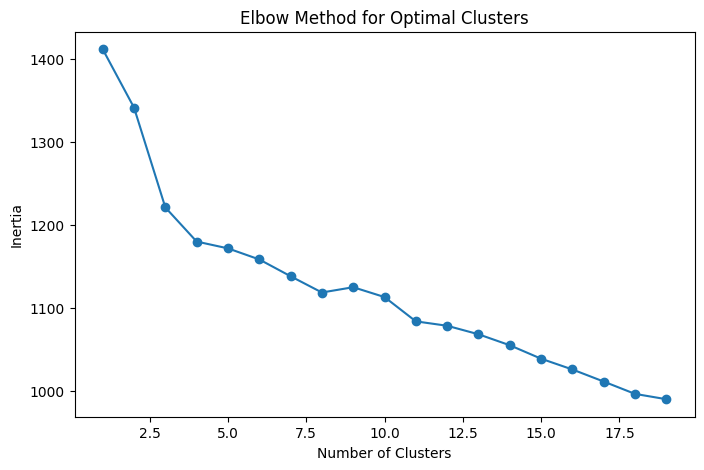

In [92]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min

# # Example data (e.g., embeddings from word2vec)
# # Replace `data` with your dataset or embeddings
# data = embeddings  # Use embeddings or your numeric data

# # Calculate inertia for different numbers of clusters
# inertia = []
# range_clusters = range(1, 20)  # Test cluster numbers 1-10
# for k in range_clusters:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(data)
#     inertia.append(kmeans.inertia_)

# # Plot the elbow curve
# plt.figure(figsize=(8, 5))
# plt.plot(range_clusters, inertia, marker='o')
# plt.title("Elbow Method for Optimal Clusters")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Inertia")
# plt.show()

In [116]:
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # Sample documents
# documents = valid_documents

# # Create a count matrix
# vectorizer = CountVectorizer()
# count_matrix = vectorizer.fit_transform(documents).toarray()

# # Create a word-to-index mapping
# vocab = vectorizer.get_feature_names_out()
# word_to_index = {word: idx for idx, word in enumerate(vocab)}

# # Find co-occurrence vectors for a target word
# keywords = {"economy": [], "democracy": [], "security": [], "immigration": [], "education": [], "healthcare": [], "abortion": []}
# for keyword in keywords:
#     if keyword in word_to_index:
#         target_idx = word_to_index[keyword]
#         target_vector = count_matrix[:, target_idx]
    
#         # Calculate cosine similarity with all other words
#         similarities = cosine_similarity(target_vector.reshape(1, -1), count_matrix.T).flatten()
    
#         # Get top related words
#         related_indices = similarities.argsort()[::-1][1:21]
#         print(f"Words most related to '{keyword}':")
#         for idx in related_indices:
#             keywords[keyword].append(vocab[idx])
#             # print(f"{vocab[idx]}: {similarities[idx]:.2f}")
#         # print(keyword + ": ")
#         print(keywords[keyword])
#     else:
#         print(f"'{target_word}' not found in the vocabulary.")

Words most related to 'economy':
['prices', 'inflation', 'triggering', 'stock', 'scores', 'expensive', 'felt', 'rates', 'respondents', 'professional', 'economic', 'stamps', 'repercussions', 'roxanne', 'afloat', 'aquaculture', 'priced', 'manageable', 'succumbing', 'necessities']
Words most related to 'democracy':
['siphoned', 'mudde', 'legalized', 'hence', 'capitalism', 'rectify', 'columns', 'newest', 'reich', 'acquisitions', 'robertreich', 'stalled', 'nausea', 'misallocation', 'inbox', 'rigs', 'cas', 'eldercare', 'summoned', 'corporations']
Words most related to 'security':
['social', 'shortfall', 'finances', 'insolvency', '2031', 'footing', 'mismanage', 'proposing', 'waving', 'trustees', 'insolvent', 'modernize', 'holland', 'ss', '2033', 'breck', 'dumas', 'angrily', 'buckle', 'oasi']
Words most related to 'immigration':
['immigrants', 'policies', 'border', 'forgiveness', 'country', 'about', 'sues', 'migrants', 'illegally', 'wanted', 'harris', 'illegal', 'said', 'did', 'from', 'trump',

In [118]:
# # Save dictionary to JSON file
# with open("newsarticles.json", "w") as json_file:
#     json.dump(documents, json_file, indent=4)  # `indent=4` makes it pretty-printed

# print("Dictionary saved to newsarticles.json!")

Dictionary saved to newsarticles.json!
